# Classification Project 

The main goal of this project is to create a classiication model and get the highest F1.
The F1 score is a measure of a model's accuracy that considers both precision and recall, making it a balanced metric for classification problems, especially when you have imbalanced classes.

# Step 1: Import Libraries

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score,classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
import json


from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

import scikit_posthocs as sp   # For DeLong test
import statsmodels.stats.multitest as mt # For Bonferroni correction


In [2]:
# !pip install xgboost

# Step 2: Load Data

In [3]:
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv")
X_test = pd.read_csv("X_test.csv")  # will be used only for final submission step

In [4]:
X_train.head(2)

,Unnamed: 0,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,id,Race
0,1847,Bachelors,2016,Bangalore,3,27.0,Male,Yes,4,1847,white
1,2905,Bachelors,2012,Bangalore,3,28.0,Male,No,4,2905,white


In [5]:
X_train.columns

Index(['Unnamed: 0', 'Education', 'JoiningYear', 'City', 'PaymentTier', 'Age',
       'Gender', 'EverBenched', 'ExperienceInCurrentDomain', 'id', 'Race'],
      dtype='object')

In [6]:
# Drop the 'Unnamed: 0' column
X_train.drop('Unnamed: 0', axis=1, inplace=True)

# Set the 'id' column as the index of the dataframe
X_train.set_index('id', inplace=True)

# View the new data frame
X_train.head(2)

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,Race
id,,,,,,,,,
1847,Bachelors,2016,Bangalore,3,27.0,Male,Yes,4,white
2905,Bachelors,2012,Bangalore,3,28.0,Male,No,4,white


In [7]:
X_test.head(2)

,Unnamed: 0,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,id,Race
0,911,Bachelors,2014,Bangalore,3,25.0,Female,No,2,911,white
1,2235,Bachelors,2016,Bangalore,3,28.0,Female,No,5,2235,white


In [8]:
# Drop the 'Unnamed: 0' column
X_test.drop('Unnamed: 0', axis=1, inplace=True)

# Set the 'id' column as the index of the dataframe
X_test.set_index('id', inplace=True)

# View the new data frame
X_test.head(2)

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,Race
id,,,,,,,,,
911,Bachelors,2014,Bangalore,3,25.0,Female,No,2,white
2235,Bachelors,2016,Bangalore,3,28.0,Female,No,5,white


In [9]:
y_train.head(2)

,Unnamed: 0,LeaveOrNot
0,1847,0
1,2905,0


In [10]:
# Set the 'id' column as the index of the dataframe
y_train.set_index('Unnamed: 0', inplace=True)

# View the new data frame
y_train.head(2)

,LeaveOrNot
Unnamed: 0,
1847,0
2905,0


In [11]:
# y_train.info()

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3722 entries, 1847 to 2575
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Education                  3722 non-null   object 
 1   JoiningYear                3722 non-null   int64  
 2   City                       3722 non-null   object 
 3   PaymentTier                3722 non-null   int64  
 4   Age                        3720 non-null   float64
 5   Gender                     3720 non-null   object 
 6   EverBenched                3722 non-null   object 
 7   ExperienceInCurrentDomain  3722 non-null   int64  
 8   Race                       3722 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 290.8+ KB


In [13]:
X_train.shape

(3722, 9)

In [14]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3722 entries, 1847 to 2575
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   LeaveOrNot  3722 non-null   int64
dtypes: int64(1)
memory usage: 58.2 KB


In [15]:
y_train.shape

(3722, 1)

Check for any missing values

In [16]:
X_train.isnull().sum()

Education                    0
JoiningYear                  0
City                         0
PaymentTier                  0
Age                          2
Gender                       2
EverBenched                  0
ExperienceInCurrentDomain    0
Race                         0
dtype: int64

In [17]:
y_train.isnull().sum()

LeaveOrNot    0
dtype: int64

Check for imbalanced data

In [18]:
y_train['LeaveOrNot'].value_counts()

0    2415
1    1307
Name: LeaveOrNot, dtype: int64

In [19]:
X_test.isnull().sum()

Education                    0
JoiningYear                  0
City                         0
PaymentTier                  0
Age                          0
Gender                       0
EverBenched                  0
ExperienceInCurrentDomain    0
Race                         0
dtype: int64

Examine the rows with the missing values:

In [20]:
X_train[X_train.isna().any(axis=1)]

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,Race
id,,,,,,,,,
0,Bachelors,2017,Bangalore,3,NaN,NaN,No,0,white
1,Bachelors,2013,Pune,1,NaN,NaN,No,3,white


In [21]:
[(col, X_train[col].unique()) for col in X_train.columns]

[('Education', array(['Bachelors', 'PHD', 'Masters'], dtype=object)),
 ('JoiningYear',
  array([2016, 2012, 2015, 2017, 2014, 2013, 2018], dtype=int64)),
 ('City', array(['Bangalore', 'Pune', 'New Delhi'], dtype=object)),
 ('PaymentTier', array([3, 2, 1], dtype=int64)),
 ('Age',
  array([27., 28., 26., 29., 24., 40., 23., 42., 37., 35., 30., 33., 32.,
         39., 41., 31., 34., 25., 36., 38., 43., nan])),
 ('Gender', array(['Male', 'Female', nan], dtype=object)),
 ('EverBenched', array(['Yes', 'No'], dtype=object)),
 ('ExperienceInCurrentDomain', array([4, 2, 1, 0, 5, 3, 6, 7], dtype=int64)),
 ('Race', array(['white', 'black', 'yellow', 'red'], dtype=object))]

Age and gender statistics

In [22]:
X_train['Age'].mean()

30.928763440860216

In [23]:
# Consider imbalanced data
X_train['Gender'].value_counts()

Male      2218
Female    1502
Name: Gender, dtype: int64

In [24]:
# Impute missing 'Age' values with the mean age
# X_train['Age'].fillna(X_train['Age'].mean(), inplace=True)

In [25]:
# Impute missing 'Gender' values with the mode (most frequent category)
# X_train['Gender'].fillna(X_train['Gender'].mode()[0], inplace=True)
# X_train['Gender'].value_counts()

In [26]:
# [(col, X_train[col].unique()) for col in X_train.columns]

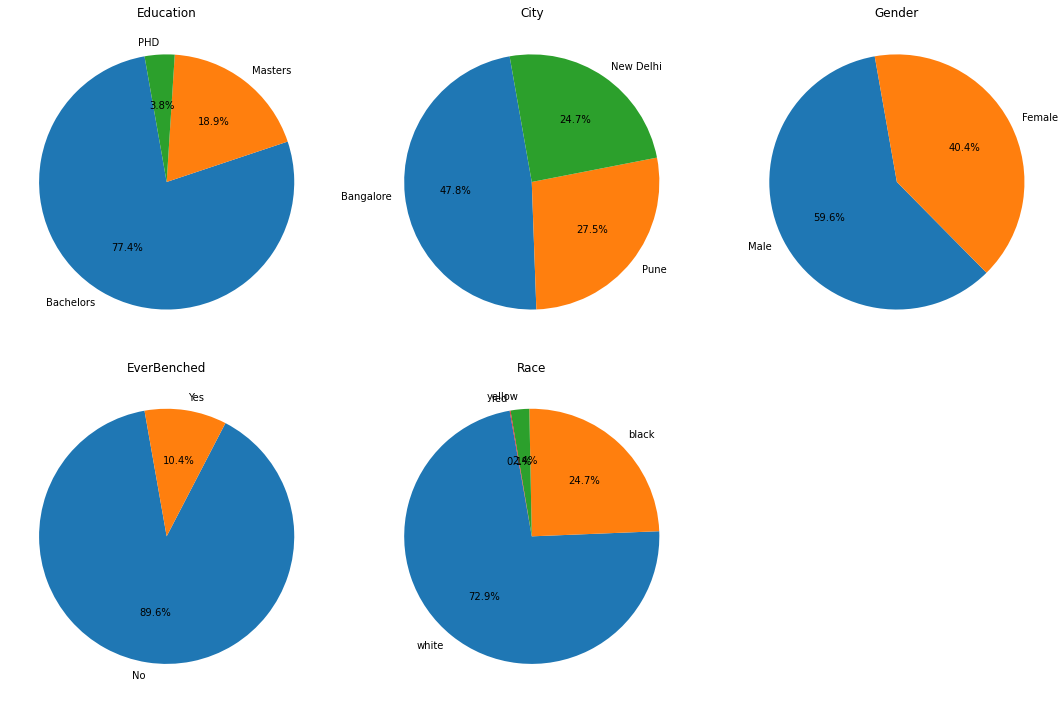

In [27]:
categorical_cols = ['Education', 'City', 'Gender', 'EverBenched', 'Race']

# Set the figure size and layout for multiple pie charts
plt.figure(figsize=(15, 10))  # Adjust the size as needed

# Iterate through each categorical column
for i, col in enumerate(categorical_cols):
    # Count the frequency of each category in the column
    col_count = X_train[col].value_counts()
    
    # Create a subplot for each pie chart
    plt.subplot(2, 3, i+1)  # Adjust the grid dimensions as needed
    plt.pie(col_count, labels=col_count.index, autopct='%1.1f%%', startangle=100)
    plt.title(col)  # Title with the name of the categorical column

plt.tight_layout()  # Adjust the layout

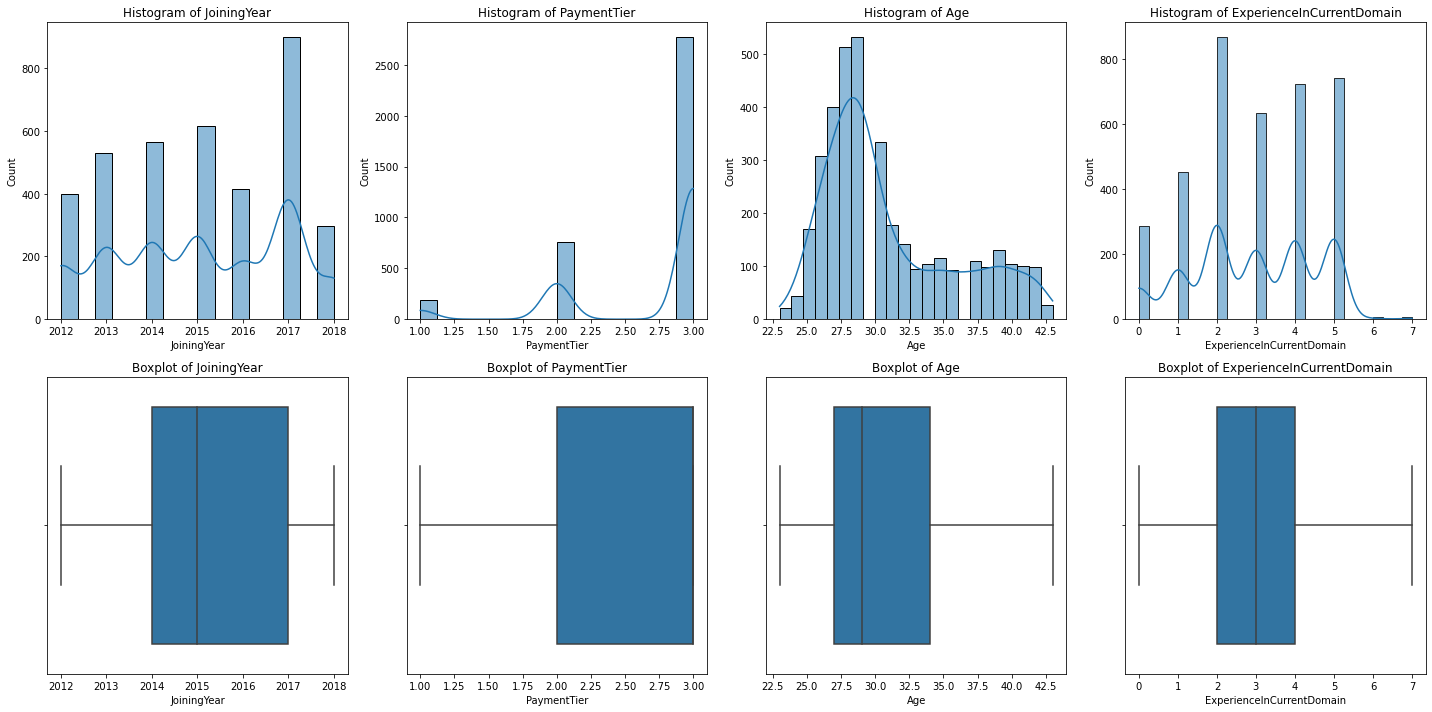

In [28]:
numerical_cols = ['JoiningYear', 'PaymentTier', 'Age', 'ExperienceInCurrentDomain']

# Set the figure size for multiple plots
plt.figure(figsize=(20, 10))

# Create histograms
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 4, i+1)
    sns.histplot(X_train[col], kde=True)
    plt.title(f'Histogram of {col}')

# Create boxplots
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 4, i+5)
    sns.boxplot(x=X_train[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()

# Step 3: Split Data

In [29]:
X_train_tts, X_test_tts, y_train_tts, y_test_tts = tts(X_train, y_train, test_size=0.2, random_state=123)

# Step 4: Define Column Transformer

In [30]:
numerical_cols = ['JoiningYear', 'PaymentTier', 'Age', 'ExperienceInCurrentDomain']
categorical_cols = ['Education', 'City', 'Gender', 'EverBenched', 'Race']


# Define transformers for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder())
])

# Create the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)  
    ])


# SMOTE

In [31]:
# Apply preprocessing to the training data
X_train_preprocessed = preprocessor.fit_transform(X_train_tts)

In [32]:
# If y_train_tts is a Series or 1D numpy array:
print("Before SMOTE:", Counter(y_train_tts['LeaveOrNot']))

# Apply SMOTE
smote = SMOTE(random_state=123)
X_train_tts_smote, y_train_tts_smote = smote.fit_resample(X_train_preprocessed, y_train_tts)

# After SMOTE
print("After SMOTE:", Counter(y_train_tts_smote['LeaveOrNot']))

Before SMOTE: Counter({0: 1930, 1: 1047})
After SMOTE: Counter({0: 1930, 1: 1930})


# Customize Models and Hyperparameters


In [33]:
# Define your customized RandomForestClassifier
rf = RandomForestClassifier(random_state=123)
lg = LogisticRegression(random_state=123) 
adaboost = AdaBoostClassifier(random_state=123) # tree is default estimator
grdboost = GradientBoostingClassifier(random_state=123)
xgb = xgb.XGBClassifier(objective="multi:softmax", num_class=3, random_state=123) #  objective='binary:hinge'


# Models with penalizing for imbalanced data
rf_penalize = RandomForestClassifier(random_state=123, class_weight='balanced')
lg_penalize = LogisticRegression(random_state=123, class_weight='balanced')

#Voting:
# voting_calssifiers = [('rf', rf), ('xgb', xgb)]
# voting = VotingClassifier(estimators = [('rf', rf), ('xgb', xgb)])

In [34]:
# Hyperparameter grid (adjusted for use with pipeline)
rf_param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__min_samples_leaf': [10, 25],
    'classifier__max_depth': [5, 10]
    # 'classifier__criterion': ['gini', 'entropy']
}

In [35]:
# Grid search
lg_param_grid = {'classifier__penalty': ['l1', 'l2'], 
                 'classifier__C': [0.001, 0.01, 1], 
                 'classifier__tol': [0.0001, 0.001], 
                 'classifier__solver': ['liblinear'],
                 'classifier__max_iter': [500]}

In [36]:
ada_param_grid = {'classifier__n_estimators': [10, 50, 100], 
                 'classifier__learning_rate': [0.01, 1, 5]}

In [37]:
grdboost_param_grid = {'classifier__n_estimators': [50, 100], 
                       'classifier__learning_rate': [0.1, 1],
                       'classifier__max_depth': [3, 10]}

In [38]:
xgboost_param_grid = {'classifier__learning_rate' : [0.01, 0.1, 1],
                      'classifier__max_depth' : [2, 4, 8],
                      'classifier__min_child_weight' : [0,2,4]}
                  
        
# voting_param_grid = {'classifier__voting': ['soft', 'hard']
# }

# Create a Pipeline and Train the Model

In [39]:
def model_generator(model, param_grid):
    # Create the pipline
    pipeline = Pipeline([('classifier',model)])
    # GridSearchCV with the pipeline
    model_gs = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=10, scoring='f1')
    # Fit GridSearchCV 
    model_gs.fit(X_train_tts_smote, y_train_tts_smote.values.ravel())
    return model_gs

In [40]:
# model_gs.named_steps['classifier']
# dir(model_gs)
# model_gs.steps[1][1].feature_importance_

In [41]:
# f = best_model.named_steps['classifier']
# f.feature_importance_

Random Forest

In [42]:
# Get the grid search of model
rf_grid = model_generator(rf, rf_param_grid)

# Output the best parameters
print("Best Parameters:", rf_grid.best_params_)

# Define the best estimator
rf_best_model = rf_grid.best_estimator_

Best Parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 10, 'classifier__n_estimators': 100}


Logistic Regression

In [43]:
# Get the grid search of model
lg_grid = model_generator(lg, lg_param_grid)

# Output the best parameters
print("Best Parameters:", lg_grid.best_params_)

# Define the best estimator
lg_best_model = lg_grid.best_estimator_

Best Parameters: {'classifier__C': 0.01, 'classifier__max_iter': 500, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear', 'classifier__tol': 0.0001}


Adaboost

In [44]:
# Get the grid search of model
ada_grid = model_generator(adaboost, ada_param_grid)

# Output the best parameters
print("Best Parameters:", ada_grid.best_params_)

# Define the best estimator
ada_best_model = ada_grid.best_estimator_

Best Parameters: {'classifier__learning_rate': 1, 'classifier__n_estimators': 100}


Gradientboost

In [45]:
# Get the grid search of model
grd_grid = model_generator(grdboost, grdboost_param_grid)

# Output the best parameters
print("Best Parameters:", grd_grid.best_params_)

# Define the best estimator
grd_best_model = grd_grid.best_estimator_

Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__n_estimators': 50}


XGBoost

In [46]:
# Get the grid search of model
xgb_grid = model_generator(xgb, xgboost_param_grid)

# Output the best parameters
print("Best Parameters:", xgb_grid.best_params_)

# Define the best estimator
xgb_best_model = xgb_grid.best_estimator_

Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 8, 'classifier__min_child_weight': 2}


#  Evaluate the Model

In [47]:
# Preprocess the test set
X_test_tts = preprocessor.transform(X_test_tts)

In [50]:
def class_report_func(x_data, y_data, model):
    predictions = model.predict(x_data)
    print(classification_report(y_data, predictions))
     
# predictions = xgb_best_model.predict(dataset)    

In [58]:
print( "The random forest report is: ") 
class_report_func(X_test_tts, y_test_tts, rf_best_model)

print( "The logistic regression report is: ") 
class_report_func(X_test_tts, y_test_tts, lg_best_model)

print( "The adaboost report is: ") 
class_report_func(X_test_tts, y_test_tts, ada_best_model)

print( "The gradientboost report is: ") 
class_report_func(X_test_tts, y_test_tts, grd_best_model)

print( "The xgboost report is: ") 
class_report_func(X_test_tts, y_test_tts, xgb_best_model)

The random forest report is: 
              precision    recall  f1-score   support

           0       0.84      0.91      0.87       485
           1       0.80      0.68      0.73       260

    accuracy                           0.83       745
   macro avg       0.82      0.79      0.80       745
weighted avg       0.83      0.83      0.82       745

The logistic regression report is: 
              precision    recall  f1-score   support

           0       0.79      0.71      0.74       485
           1       0.54      0.65      0.59       260

    accuracy                           0.68       745
   macro avg       0.66      0.68      0.67       745
weighted avg       0.70      0.68      0.69       745

The adaboost report is: 
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       485
           1       0.75      0.61      0.67       260

    accuracy                           0.79       745
   macro avg       0.78      0.75    

In [66]:
def f1_func(x_data, y_data, model):
    predictions = model.predict(x_data)
    the_f1 = f1_score(y_data, predictions)
    return round(the_f1,2)     

In [68]:
print( f"The random forest f1 is: {f1_func(X_test_tts, y_test_tts, rf_best_model)} ") 
print( f"The logistic regression f1 is: {f1_func(X_test_tts, y_test_tts, lg_best_model)} ") 
print( f"The adaboost f1 is: {f1_func(X_test_tts, y_test_tts, ada_best_model)} ") 
print( f"The gradientboost f1 is: {f1_func(X_test_tts, y_test_tts, grd_best_model)} ") 
print( f"The xgboost f1 is: {f1_func(X_test_tts, y_test_tts, xgb_best_model)} ") 

The random forest f1 is: 0.73 
The logistic regression f1 is: 0.59 
The adaboost f1 is: 0.67 
The gradientboost f1 is: 0.69 
The xgboost f1 is: 0.71 


Text(33.0, 0.5, 'Actual')

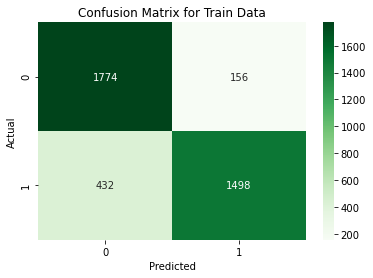

In [266]:
# Confusion Matrix for Training Data
conf_matrix_train = confusion_matrix(y_train_tts_smote, rf_best_model.predict(X_train_tts_smote))
sns.heatmap(conf_matrix_train, annot=True, fmt='g', cmap='Greens')
plt.title('Confusion Matrix for Train Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')

Text(33.0, 0.5, 'Actual')

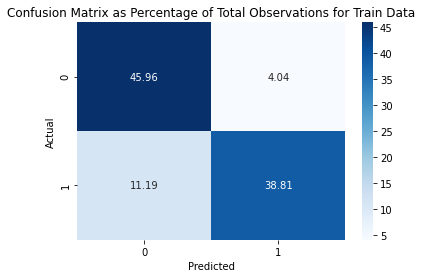

In [267]:
# Calculate the percentage for each cell
total = np.sum(conf_matrix_train)
conf_matrix_percentage_train = (conf_matrix_train / total) * 100

# Plotting the confusion matrix as a heatmap
sns.heatmap(conf_matrix_percentage_train, annot=True, fmt='.2f', cmap='Blues')
plt.title('Confusion Matrix as Percentage of Total Observations for Train Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')

Text(33.0, 0.5, 'Actual')

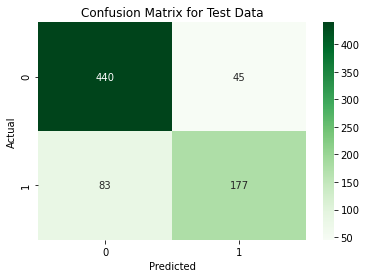

In [268]:
# Confusion Matrix for Test Data
conf_matrix_test = confusion_matrix(y_test_tts, predictions)
sns.heatmap(conf_matrix_test, annot=True, fmt='g', cmap='Greens')
plt.title('Confusion Matrix for Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')

Text(33.0, 0.5, 'Actual')

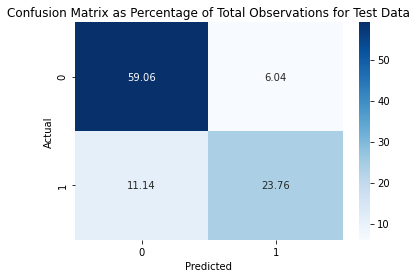

In [269]:
# Calculate the percentage for each cell
total = np.sum(conf_matrix_test)
conf_matrix_percentage_test = (conf_matrix_test / total) * 100

# Plotting the confusion matrix as a heatmap
sns.heatmap(conf_matrix_percentage_test, annot=True, fmt='.2f', cmap='Blues')
plt.title('Confusion Matrix as Percentage of Total Observations for Test Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')

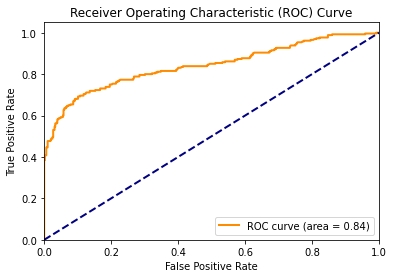

In [70]:
# ROC Curve for Test Data
y_test_proba = rf_best_model.predict_proba(X_test_tts)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test_tts, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

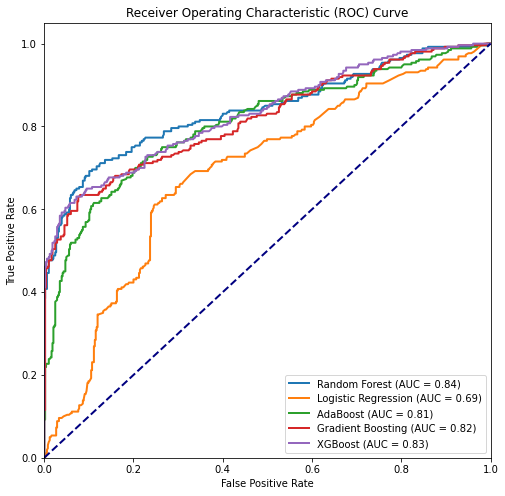

In [76]:
# Calculating the ROC curve and AUC for each model
models = {
    "Random Forest": rf_best_model,
    "Logistic Regression": lg_best_model,
    "AdaBoost": ada_best_model,
    "Gradient Boosting": grd_best_model,
    "XGBoost": xgb_best_model
}

plt.figure(figsize=(8, 8))

for name, model in models.items():
    y_test_proba = model.predict_proba(X_test_tts)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_tts, y_test_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:0.2f})')

# Plotting the diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Adding labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")


In [85]:
# Get the predicted probabilities for each model
pred_probs = {
    "Random Forest": rf_best_model.predict_proba(X_test_tts)[:, 1],
    "Logistic Regression": lg_best_model.predict_proba(X_test_tts)[:, 1],
    "AdaBoost": ada_best_model.predict_proba(X_test_tts)[:, 1],
    "Gradient Boosting": grd_best_model.predict_proba(X_test_tts)[:, 1],
    "XGBoost": xgb_best_model.predict_proba(X_test_tts)[:, 1]
}

# Prepare data for the DeLong test
# Stack model predictions and corresponding true labels
stacked_predictions = np.hstack([probs.reshape(-1, 1) for probs in pred_probs.values()])
stacked_model_names = np.array([[name] * len(y_test_tts) for name in pred_probs.keys()]).flatten()
stacked_true_labels = np.tile(y_test_tts, len(pred_probs))

stacked_data = pd.DataFrame({
    "Model": stacked_model_names,
    "Predictions": stacked_predictions.flatten(),
    "True Labels": stacked_true_labels
})

# Perform the DeLong test
p_values = sp.posthoc_dscf(stacked_data, val_col='Predictions', group_col='Model')

# Flatten the matrix of p-values and apply Bonferroni correction
p_values_flattened = p_values.values.flatten()
corrected_p_values = mt.multipletests(p_values_flattened, method='bonferroni')[1]

# Reshape the corrected p-values back into a matrix
n = len(pred_probs)
corrected_p_value_matrix = corrected_p_values.reshape(n, n)

# Create a DataFrame for better visualization
corrected_p_value_matrix_df = pd.DataFrame(corrected_p_value_matrix, index=pred_probs.keys(), columns=pred_probs.keys())

print(corrected_p_value_matrix_df)

Exception: Data must be 1-dimensional

# Submission

In [ ]:
X_test.head(2)

In [ ]:
X_test.shape
X_test.isnull().sum()

In [ ]:
# external test dataset should undergo the same preprocessing steps as training dataset
X_test_proc = preprocessor.transform(X_test)
# Get the feature names for categorical columns after one-hot encoding
# 'onehot' is the name of the OneHotEncoder step in your categorical pipeline
one_hot_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols)

# Combine with the numerical column names
all_feature_names = numerical_cols + list(one_hot_feature_names)

# Convert to DataFrame
X_test_proc_df = pd.DataFrame(X_test_proc, columns=all_feature_names, index=X_test.index)

# Display the first two rows of the processed DataFrame
X_test_proc_df.head(2)

Picked the best model to generate predictions:

In [ ]:
final_y_pred = best_model.predict(X_test_proc)  # best_model inner pipeline ensurses the preprocessing of X_test
final_y_pred.shape

Create a dictionary with the predicted values {id: prediction}

In [ ]:
prediction_dict = {id_: pred for id_, pred in zip(X_test.index, final_y_pred)}

# Convert NumPy int64 types to native Python int types in the dictionary (JASON requirement)
prediction_dict_converted = {int(id_): int(pred) for id_, pred in prediction_dict.items()}

 Convert dictionary to JSON File

In [ ]:
with open('Daria_non_final_predictions.json', 'w') as f:
    json.dump(prediction_dict_converted, f)